In [1025]:
# !pip install pmdarima
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA
import datetime
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [1026]:
import sys
# sys.path.append('/Users/gabrielarnold/Desktop/FlatIron/notes/proj5/')
from datacleaner import create_dataframe
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score

### Sales Data

In [1027]:
median_sale = pd.read_csv('./data/medianSalesPrice_All.csv')

In [1028]:
def dickey_fuller_test(series):
    dftest = adfuller(series, autolag='AIC', regression='ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [1029]:
def create_dataframe(csv_file):
    new_data = pd.melt(csv_file,id_vars=['areaName','Borough', 'areaType'])
    new_data['variable'] = pd.to_datetime(new_data['variable'], infer_datetime_format=True)
    new_data.set_index('variable', inplace=True)
    return new_data

In [1030]:
def select_data(dataframe, borough):
    new_data = dataframe[dataframe['Borough'] == borough]
    new_data = new_data[new_data['areaType']=='borough']
    return new_data

In [1031]:
median_sale = create_dataframe(median_sale)

In [1032]:
bronx_sales_data = select_data(median_sale,'Bronx')

In [1059]:
bronx_sales_data.tail(6)

,areaName,Borough,areaType,value
variable,,,,
2020-01-01,Bronx,Bronx,borough,458000.0
2020-02-01,Bronx,Bronx,borough,454000.0
2020-03-01,Bronx,Bronx,borough,525000.0
2020-04-01,Bronx,Bronx,borough,542900.0
2020-05-01,Bronx,Bronx,borough,484500.0
2020-06-01,Bronx,Bronx,borough,500000.0


In [1033]:
manhattan_sales_data = select_data(median_sale,'Manhattan')

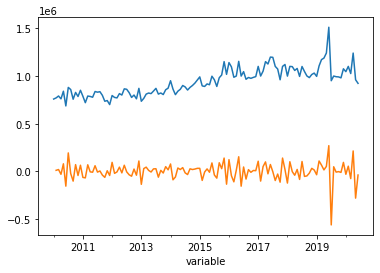

In [1060]:
manhattan_sales_data['value'].plot()
manhattan_sales_data['value'].diff().plot()

In [1034]:
brooklyn_sales_data = select_data(median_sale, 'Brooklyn')

In [1035]:
staten_island_sales_data = select_data(median_sale, 'Staten Island')

In [1036]:
queens_sales_data = select_data(median_sale, 'Queens')

In [1037]:
sales_data = pd.DataFrame({'Bronx' : bronx_sales_data['value'], 
             'Manhattan': manhattan_sales_data['value'], 
             "Brooklyn" : brooklyn_sales_data['value'],
             "Staten Island" : staten_island_sales_data['value'], 
             "Queens":queens_sales_data['value']})

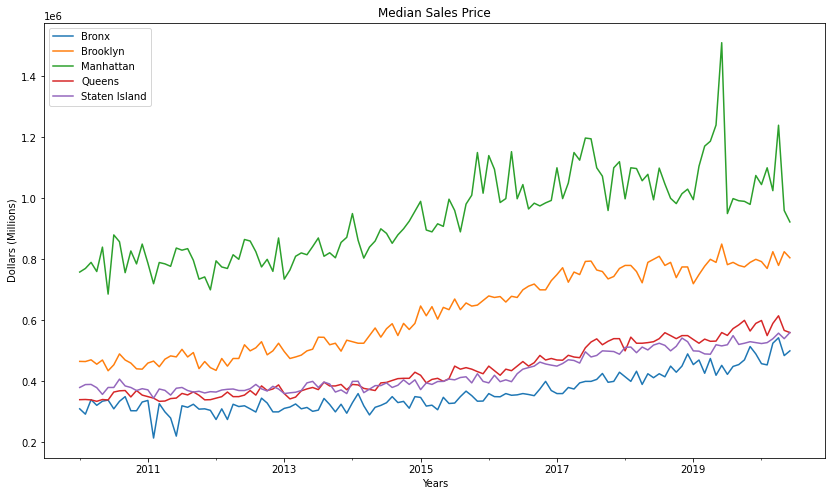

In [1039]:
sales_data.plot(figsize=(14,8), title='Median Sales Price')
plt.xlabel('Years')
plt.ylabel('Dollars (Millions)')
plt.savefig('MedianSalesPrice_all.png')

<p> Looking at the graph above, we can see how the sales prices for homes in each borough have behaved. Manhattan, is the most expensive borough, with the Bronx being the least expensive.</p>

<p> Next, I will create a basic model that will try to predict the value of homes in each borough. Then, I will add other economic factors that may possibly explain the relationship between the median sales price and other economic factors </p> 

#### Sales Volume 

In [101]:
data = pd.read_csv('./data/recordedSalesVolume_All.csv')

In [102]:
sales_volume = create_dataframe(data)

In [104]:
manhattan_sales_volume = select_data(sales_volume, 'Manhattan')

In [106]:
bronx_sales_volume = select_data(sales_volume, 'Bronx')

In [107]:
queens_sales_volume = select_data(sales_volume, 'Queens')

In [109]:
staten_island_sales_volume = select_data(sales_volume, 'Staten Island')

In [110]:
brooklyn_sales_volume = select_data(sales_volume, 'Brooklyn')

In [111]:
sales_volume_data = pd.DataFrame({'Bronx' : bronx_sales_volume['value'], 
             'Manhattan': manhattan_sales_volume['value'], 
             "Brooklyn" : brooklyn_sales_volume['value'],
             "Staten Island" : staten_island_sales_volume['value'], 
             "Queens":queens_sales_volume['value']})

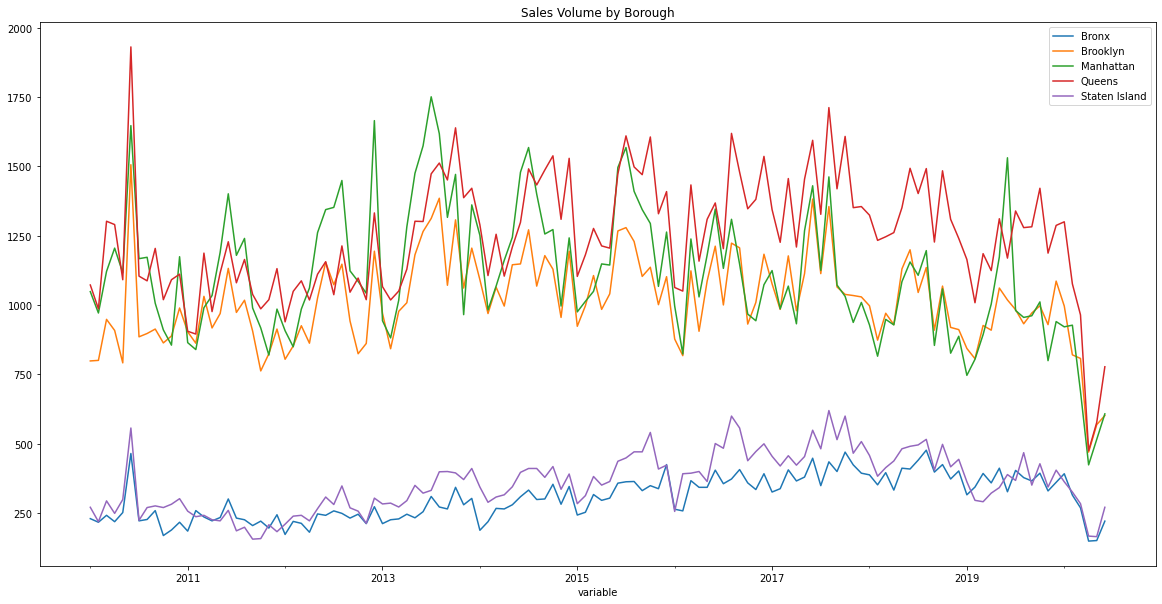

In [113]:
sales_volume_data.plot(figsize=(20,10), title='Sales Volume by Borough')

<p> As we can see with this graph, housing availability doesn't have a clear cut leader of the pack. As of about 2017, Queens seems to have the largest average number of sales. </p>

### Housing Inventory

<p>Housing Inventory across all boroughs and summed together. Data starts in 01/01/2010 and ends in 06/01/2020. I am adding this because I believe if housing shows a steady increase, then it maybe correlated with an increase in price. </p>

In [122]:
inventory = pd.read_csv('./data/inventory.csv')

In [123]:
inventory_data = create_dataframe(inventory)

In [124]:
manhattan_inventory_data = select_data(inventory_data, 'Manhattan')

In [152]:
bronx_inventory_data = select_data(inventory_data, 'Bronx')

In [166]:
staten_island_inventory_data = select_data(inventory_data, 'Staten Island')

In [154]:
brooklyn_inventory_data = select_data(inventory_data, 'Brooklyn')

In [155]:
queens_inventory_data = select_data(inventory_data, 'Queens')

In [157]:
housing_inventory_data = pd.DataFrame({'Bronx' : bronx_inventory_data['value'], 
             'Manhattan': manhattan_inventory_data['value'], 
             "Brooklyn" : brooklyn_inventory_data['value'],
             "Staten Island" : staten_island_data['value'], 
             "Queens": queens_inventory_data['value']})

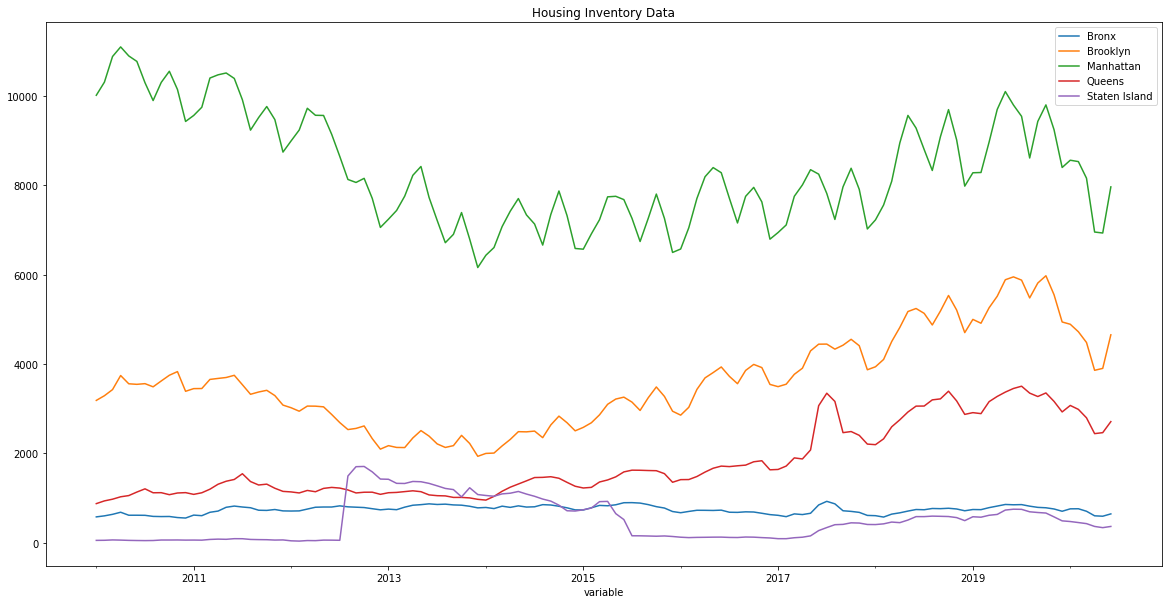

In [159]:
housing_inventory_data.plot(figsize=(20,10), title='Housing Inventory Data')

In [167]:
dickey_fuller_test(staten_island_inventory_data['value'].diff()[1:])

Test statistic = -9.409
P-value = 0.000
Critical values :
	1%: -4.033698088915276 - The data is  stationary with 99% confidence
	5%: -3.446507918792588 - The data is  stationary with 95% confidence
	10%: -3.1481686188781848 - The data is  stationary with 90% confidence


### Rental Data

<p> Rental Data starts in 01/01/2010 and ends in 06/01/2020 </p>

In [90]:
rentals = pd.read_csv('rentalasking.csv')

In [91]:
rentals_data = pd.melt(rentals, id_vars=['areaName','Borough','areaType'])
rentals_data['variable'] = pd.to_datetime(rentals_data['variable'], infer_datetime_format=True)
rentals_data.set_index('variable', inplace=True)

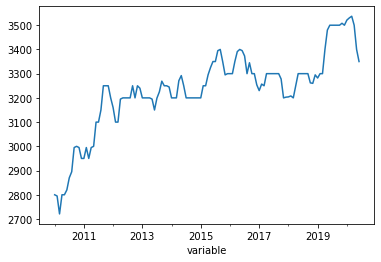

In [141]:
rentals_data[rentals_data['areaName']=='Manhattan']['value'].plot()

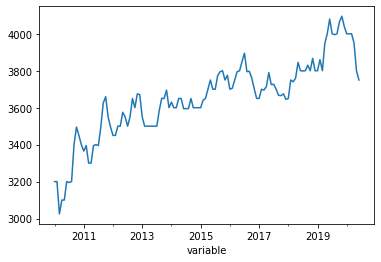

In [138]:
rentals_data[rentals_data['areaName']=='All Downtown']['value'].plot()

In [144]:
rentals_data.to_csv('final_rentals_data.csv')

In [146]:
inventory_data.to_csv('final_inventory_data.csv')

In [153]:
combined_df = pd.concat([rentals_data['value'], inventory_data['value']], join="inner")

In [157]:
manhattan_rent = rentals_data[rentals_data['areaName']=='Manhattan']
manhattan_inventory = inventory_data[inventory_data['areaName']=='Manhattan']

In [161]:
manhattan_df = pd.DataFrame(data = manhattan_rent['value'], index=manhattan_rent.index)

In [170]:
manhattan_df = manhattan_df.join(manhattan_inventory['value'], lsuffix='_inventory')

In [177]:
granger_test = sm.tsa.stattools.grangercausalitytests(manhattan_df, maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2429  , p=0.2671  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.2735  , p=0.2591  , df=1
likelihood ratio test: chi2=1.2671  , p=0.2603  , df=1
parameter F test:         F=1.2429  , p=0.2671  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8933  , p=0.4120  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.8616  , p=0.3942  , df=2
likelihood ratio test: chi2=1.8477  , p=0.3970  , df=2
parameter F test:         F=0.8933  , p=0.4120  , df_denom=119, df_num=2


<p> The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern. </p>

### Economic Data

<p> Consumer Price Index Data. Starts in 1970 and ends in 2020. </p>

In [96]:
cpi = pd.read_csv('conpriceindex.csv')

In [102]:
cpi['DATE'] = pd.to_datetime(cpi['DATE'], infer_datetime_format=True)
cpi.set_index('DATE', inplace=True)

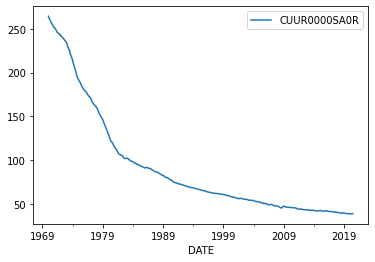

In [103]:
cpi.plot()

<p> Unemployment Data for US. Starts at 1970 and ends in 2020. </p>

In [104]:
unemployment_data = pd.read_csv('unemploymentrate.csv')

In [108]:
unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'], infer_datetime_format=True)
unemployment_data.set_index('DATE', inplace=True)

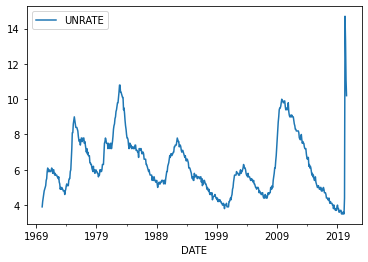

In [109]:
unemployment_data.plot()

### NYC Unemployment Rate

In [110]:
nyc_unemployment = pd.read_csv('nyc_unemployment.csv')

In [111]:
nyc_unemployment.head(5)
nyc_unemployment

,DATE,LAUST360000000000003A
0,1976-01-01,10.2
1,1977-01-01,9.1
2,1978-01-01,7.8
3,1979-01-01,7.2
4,1980-01-01,7.5


<p> I am trying to do a multi-variate time series analysis to project NYC borough populations. So far, I've gathered data on the number of housing sales, the avialability of rentals, the unemployment rate both nationwide and citywide. I believe that capturing relationships in the people's income, availability of jobs, unemployment rate, will show or account for factors of population growth. </p>

### AR Models

#### Baseline Model - Manhattan Median Asking Price

In [1041]:
dickey_fuller_test(manhattan_sales_data['value'])

Test statistic = -1.497
P-value = 0.830
Critical values :
	1%: -4.039012576443273 - The data is not stationary with 99% confidence
	5%: -3.44903886706097 - The data is not stationary with 95% confidence
	10%: -3.149645684529911 - The data is not stationary with 90% confidence


In [1042]:
dickey_fuller_test(manhattan_sales_data['value'].diff()[1:])

Test statistic = -6.847
P-value = 0.000
Critical values :
	1%: -4.039012576443273 - The data is  stationary with 99% confidence
	5%: -3.44903886706097 - The data is  stationary with 95% confidence
	10%: -3.149645684529911 - The data is  stationary with 90% confidence


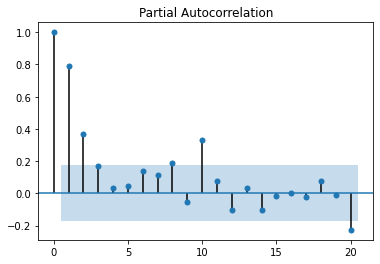

<Figure size 1440x720 with 0 Axes>

In [1061]:
plot_pacf(manhattan_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))
plt.savefig('Manhattan_PACF.png')

<Figure size 1440x720 with 0 Axes>

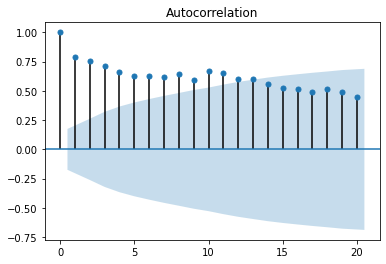

<Figure size 1440x720 with 0 Axes>

In [1044]:
plot_acf(manhattan_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

In [1045]:
test_dates = '2018-06-01'
training_dates_start = '2010-01-01'
training_dates_end = '2018-05-01'

In [1046]:
testing_set_values = manhattan_sales_data['value'][test_dates:]
testing_set = manhattan_sales_data['value'][test_dates:]
training_set = manhattan_sales_data['value'][training_dates_start:training_dates_end]

In [1047]:
dickey_fuller_test(training_set.diff()[1:])

Test statistic = -5.861
P-value = 0.000
Critical values :
	1%: -4.0630536556927295 - The data is  stationary with 99% confidence
	5%: -3.4604500192043894 - The data is  stationary with 95% confidence
	10%: -3.156294156378601 - The data is  stationary with 90% confidence


In [1048]:
def run_arma(series, p,q):
    mod_arma = ARMA(series, order=(p,q))
    res_arma = mod_arma.fit()
    return res_arma.summary()

In [1049]:
run_arma(training_set,1,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(1, 0)   Log Likelihood               -1265.116
Method:                       css-mle   S.D. of innovations          66195.763
Date:                Wed, 12 Aug 2020   AIC                           2536.231
Time:                        01:46:06   BIC                           2544.076
Sample:                    01-01-2010   HQIC                          2539.407
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.056e+05   4.37e+04     20.701      0.000     8.2e+05    9.91e+05
ar.L1.value     0.8577      0.051     16.788      0.000       0.758       0.958
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1659           +0.0000j            1.1659            0.0000
-----------------------------------------------------------------------------
"""

In [1050]:
run_arma(testing_set,1,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -327.987
Method:                       css-mle   S.D. of innovations         120510.208
Date:                Wed, 12 Aug 2020   AIC                            661.975
Time:                        01:46:24   BIC                            665.631
Sample:                    06-01-2018   HQIC                           662.989
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.066e+06   3.09e+04     34.524      0.000    1.01e+06    1.13e+06
ar.L1.value     0.2274      0.197      1.153      0.249      -0.159       0.614
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3966           +0.0000j            4.3966            0.0000
-----------------------------------------------------------------------------
"""

In [1051]:
mod_arma = ARMA(testing_set, order=(1,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


120553.7180045239

In [1052]:
pm.metrics.smape(testing_set, pred_prices)

8.081171612013648

#### Model Result

<p>Using a First Order AR Model, that excludes the Moving Average Lags, gives an RMSE of 120553 and a SMAPE Score of 8.08 </p>

In [1054]:
run_arma(training_set,2,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(2, 0)   Log Likelihood               -1256.556
Method:                       css-mle   S.D. of innovations          60701.100
Date:                Wed, 12 Aug 2020   AIC                           2521.112
Time:                        02:07:36   BIC                           2531.572
Sample:                    01-01-2010   HQIC                          2525.347
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.056e+05   6.42e+04     14.107      0.000     7.8e+05    1.03e+06
ar.L1.value     0.5213      0.090      5.767      0.000       0.344       0.699
ar.L2.value     0.3967      0.091      4.341      0.000       0.218       0.576
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0612           +0.0000j            1.0612            0.0000
AR.2           -2.3755           +0.0000j            2.3755            0.5000
-----------------------------------------------------------------------------
"""

In [1055]:
run_arma(testing_set, 2, 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(2, 0)   Log Likelihood                -327.952
Method:                       css-mle   S.D. of innovations         120325.508
Date:                Wed, 12 Aug 2020   AIC                            663.904
Time:                        02:07:39   BIC                            668.779
Sample:                    06-01-2018   HQIC                           665.256
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.066e+06   3.25e+04     32.834      0.000       1e+06    1.13e+06
ar.L1.value     0.2162      0.201      1.076      0.282      -0.177       0.610
ar.L2.value     0.0533      0.201      0.265      0.791      -0.340       0.447
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7545           +0.0000j            2.7545            0.0000
AR.2           -6.8081           +0.0000j            6.8081            0.5000
-----------------------------------------------------------------------------
"""

In [737]:
mod_arma = ARMA(testing_set, order=(2,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


120372.83440880505

In [738]:
pm.metrics.smape(testing_set, pred_prices)

8.092817643525482

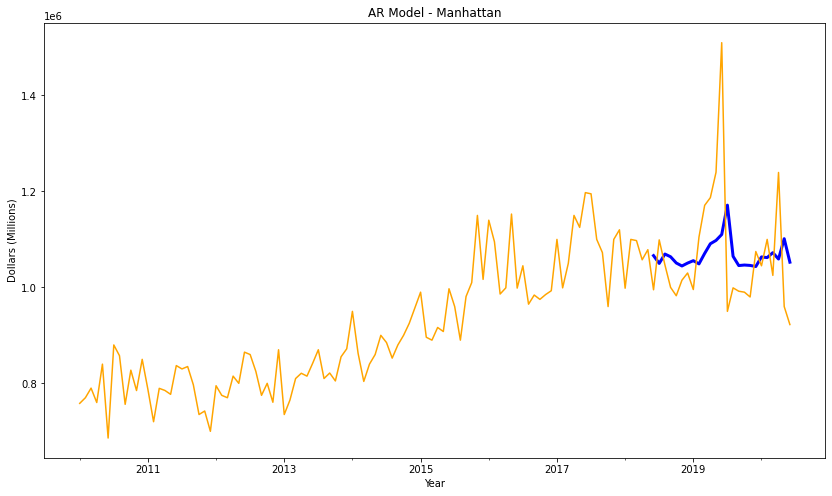

In [742]:
plt.figure(figsize=(14,8))
pred_prices.plot(color='blue', linewidth=3)
manhattan_sales_data['value'].plot(color='orange')
plt.title('AR Model - Manhattan')
plt.xlabel('Year')
plt.ylabel('Dollars (Millions)')
plt.savefig('AR_Model_Manhattan.png')

#### AR Model - Brooklyn Median Asking Price

In [205]:
dickey_fuller_test(brooklyn_sales_data['value'])

Test statistic = -1.426
P-value = 0.853
Critical values :
	1%: -4.041963001634247 - The data is not stationary with 99% confidence
	5%: -3.4504426407047193 - The data is not stationary with 95% confidence
	10%: -3.1504645425245994 - The data is not stationary with 90% confidence


In [207]:
dickey_fuller_test(brooklyn_sales_data['value'].diff().diff()[2:])

Test statistic = -8.394
P-value = 0.000
Critical values :
	1%: -4.041963001634247 - The data is  stationary with 99% confidence
	5%: -3.4504426407047193 - The data is  stationary with 95% confidence
	10%: -3.1504645425245994 - The data is  stationary with 90% confidence


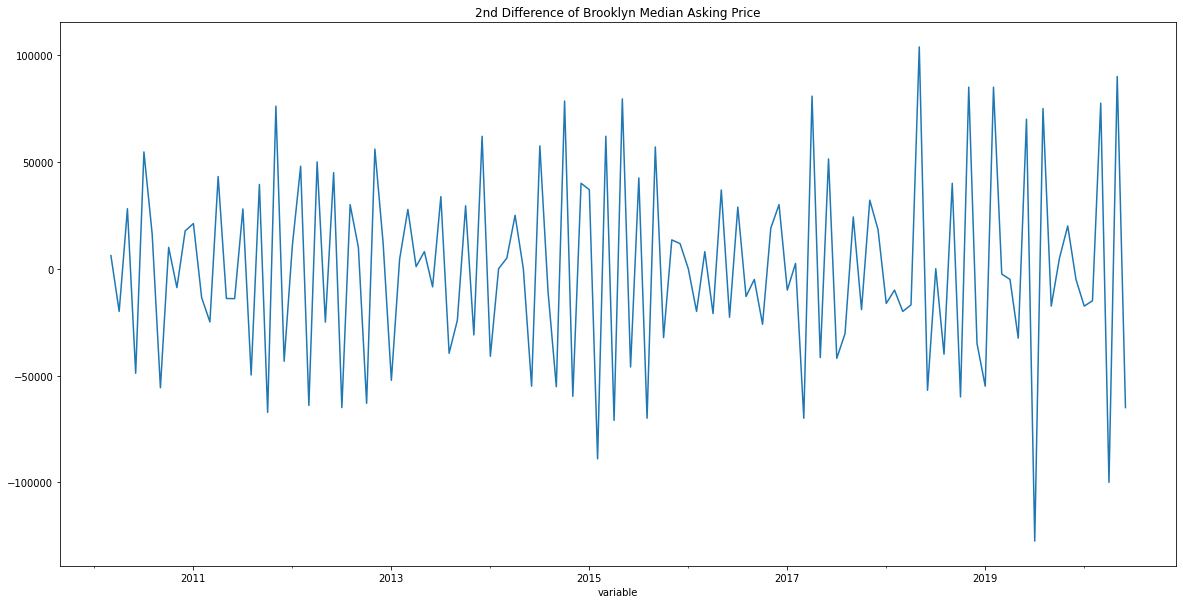

In [210]:
brooklyn_sales_data['value'].diff().diff()[2:].plot(figsize=(20,10), title='2nd Difference of Brooklyn Median Asking Price')

<Figure size 1440x720 with 0 Axes>

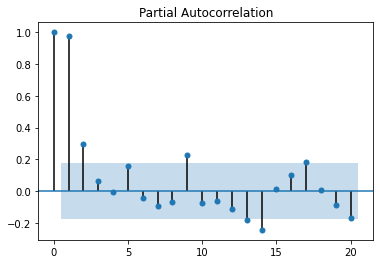

<Figure size 1440x720 with 0 Axes>

In [231]:
plot_pacf(brooklyn_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

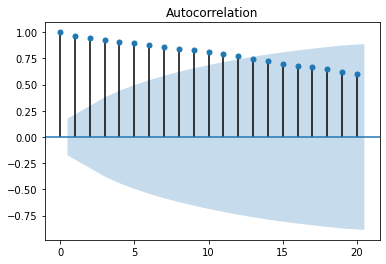

<Figure size 1440x720 with 0 Axes>

In [232]:
plot_acf(brooklyn_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

<p>Brooklyn's median asking price had to be differenced twice to achieve stationarity</p>

In [211]:
testing_set_values = brooklyn_sales_data['value'][test_dates:]
testing_set = brooklyn_sales_data['value'][test_dates:]
training_set = brooklyn_sales_data['value'][training_dates_start:training_dates_end]

In [212]:
run_arma(training_set,2,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(2, 0)   Log Likelihood               -1157.802
Method:                       css-mle   S.D. of innovations          22592.317
Date:                Mon, 10 Aug 2020   AIC                           2323.604
Time:                        22:24:05   BIC                           2334.065
Sample:                    01-01-2010   HQIC                          2327.839
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.826e+05   1.27e+05      4.601      0.000    3.34e+05    8.31e+05
ar.L1.value     0.5727      0.094      6.107      0.000       0.389       0.757
ar.L2.value     0.4182      0.094      4.441      0.000       0.234       0.603
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0065           +0.0000j            1.0065            0.0000
AR.2           -2.3760           +0.0000j            2.3760            0.5000
-----------------------------------------------------------------------------
"""

In [213]:
run_arma(testing_set, 2, 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(2, 0)   Log Likelihood                -288.601
Method:                       css-mle   S.D. of innovations          24871.317
Date:                Mon, 10 Aug 2020   AIC                            585.203
Time:                        22:24:43   BIC                            590.078
Sample:                    06-01-2018   HQIC                           586.555
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.888e+05   8388.542     94.033      0.000    7.72e+05    8.05e+05
ar.L1.value     0.1686      0.188      0.896      0.370      -0.200       0.537
ar.L2.value     0.2510      0.198      1.265      0.206      -0.138       0.640
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6882           +0.0000j            1.6882            0.0000
AR.2           -2.3598           +0.0000j            2.3598            0.5000
-----------------------------------------------------------------------------
"""

In [214]:
mod_arma = ARMA(testing_set, order=(2,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


24900.126964911273

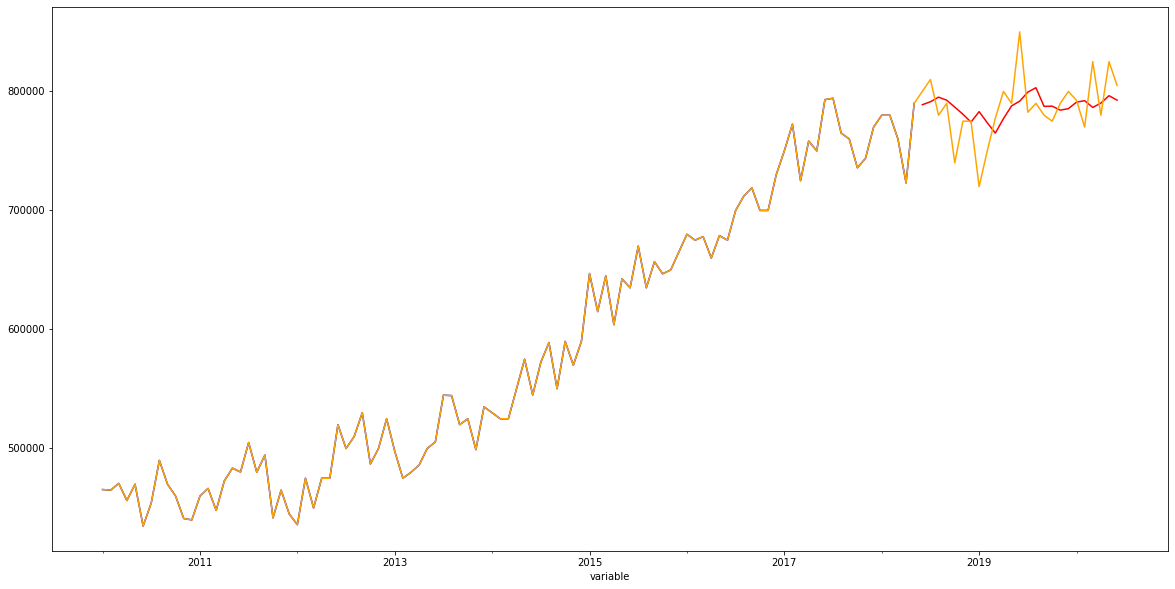

In [216]:
plt.figure(figsize=(20,10))
pred_prices.plot(color='red')
training_set.plot(color='blue')
brooklyn_sales_data['value'].plot(color='orange')

#### AR Model Bronx

In [743]:
dickey_fuller_test(bronx_sales_data['value'])

Test statistic = -1.561
P-value = 0.807
Critical values :
	1%: -4.039730383003206 - The data is not stationary with 99% confidence
	5%: -3.4493804768636473 - The data is not stationary with 95% confidence
	10%: -3.1498449798635657 - The data is not stationary with 90% confidence


In [744]:
dickey_fuller_test(bronx_sales_data['value'].diff()[1:])

Test statistic = -5.879
P-value = 0.000
Critical values :
	1%: -4.039730383003206 - The data is  stationary with 99% confidence
	5%: -3.4493804768636473 - The data is  stationary with 95% confidence
	10%: -3.1498449798635657 - The data is  stationary with 90% confidence


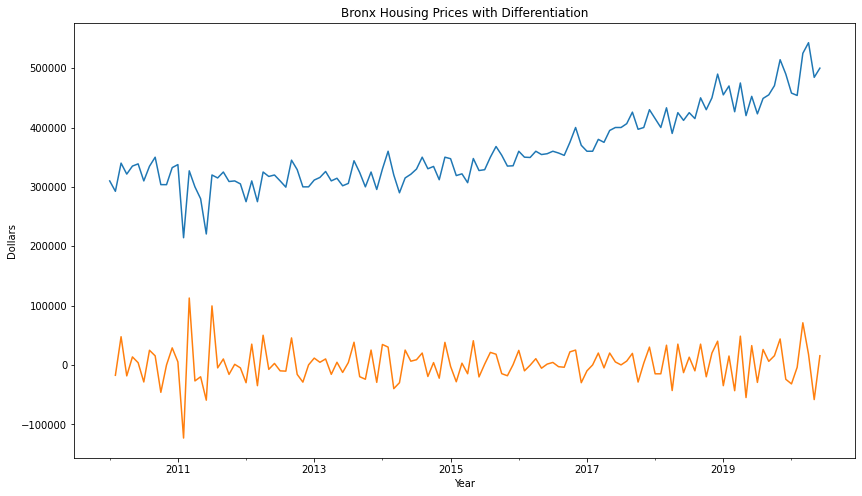

In [1063]:
plt.figure(figsize=(14,8))
bronx_sales_data['value'].plot()
bronx_sales_data['value'].diff()[1:].plot()
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.title('Bronx Housing Prices with Differentiation')
plt.savefig('bronx_housing.png')

In [1064]:
testing_set_values = bronx_sales_data['value'][test_dates:]
testing_set = bronx_sales_data['value'][test_dates:]
training_set = bronx_sales_data['value'][training_dates_start:training_dates_end]

<Figure size 1440x720 with 0 Axes>

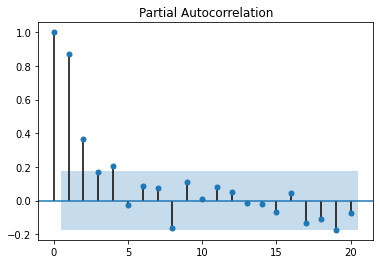

<Figure size 1440x720 with 0 Axes>

In [1065]:
plot_pacf(bronx_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

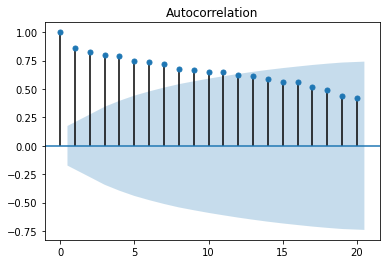

<Figure size 1440x720 with 0 Axes>

In [1066]:
plot_acf(bronx_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

In [1067]:
run_arma(training_set,1,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(1, 0)   Log Likelihood               -1176.604
Method:                       css-mle   S.D. of innovations          27636.522
Date:                Wed, 12 Aug 2020   AIC                           2359.208
Time:                        02:51:50   BIC                           2367.054
Sample:                    01-01-2010   HQIC                          2362.384
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.37e+05   9805.103     34.370      0.000    3.18e+05    3.56e+05
ar.L1.value     0.7265      0.070     10.321      0.000       0.589       0.864
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3765           +0.0000j            1.3765            0.0000
-----------------------------------------------------------------------------
"""

In [1068]:
run_arma(testing_set, 1, 0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -293.261
Method:                       css-mle   S.D. of innovations          29900.837
Date:                Wed, 12 Aug 2020   AIC                            592.522
Time:                        02:51:52   BIC                            596.178
Sample:                    06-01-2018   HQIC                           593.536
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         4.61e+05   1.16e+04     39.770      0.000    4.38e+05    4.84e+05
ar.L1.value     0.5037      0.180      2.792      0.005       0.150       0.857
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9852           +0.0000j            1.9852            0.0000
-----------------------------------------------------------------------------
"""

In [1074]:
mod_arma = ARMA(testing_set, order=(1,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

30306.212202923834

In [1075]:
pm.metrics.smape(testing_set, pred_prices)

5.324099468171897

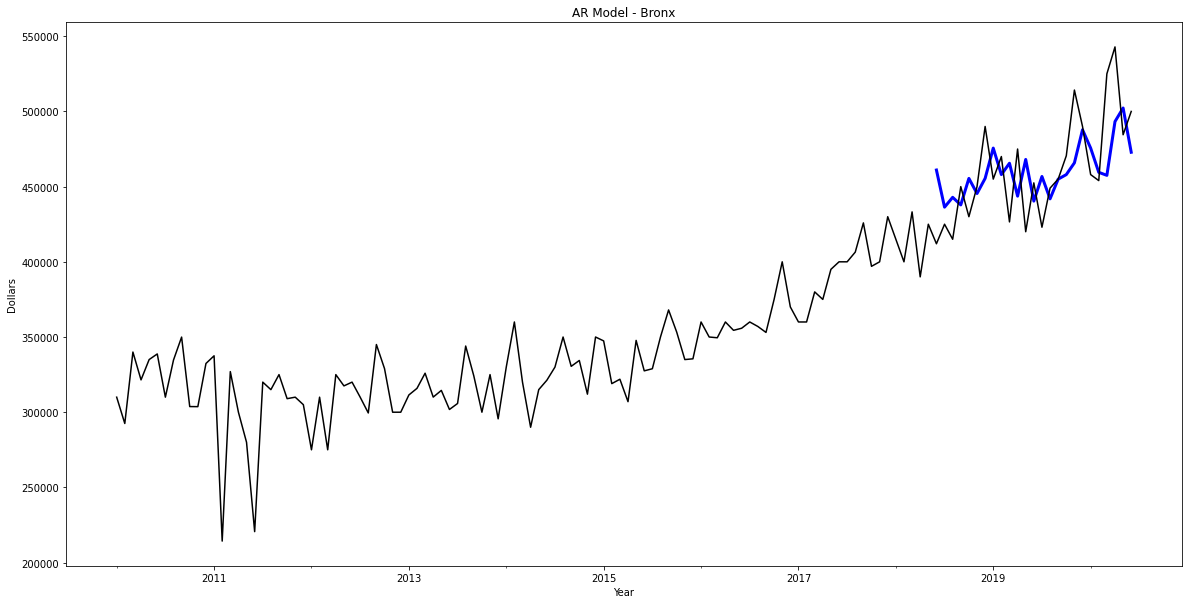

In [1076]:
plt.figure(figsize=(20,10))
pred_prices.plot(color='blue', linewidth=3)
bronx_sales_data['value'].plot(color='black')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.title('AR Model - Bronx')
plt.savefig('AR_Model_Bronx.png')

### AR Model - 2nd Order - Bronx

In [1079]:
run_arma(training_set,2,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(2, 0)   Log Likelihood               -1169.492
Method:                       css-mle   S.D. of innovations          25714.779
Date:                Wed, 12 Aug 2020   AIC                           2346.985
Time:                        02:57:53   BIC                           2357.445
Sample:                    01-01-2010   HQIC                          2351.219
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.37e+05   1.46e+04     23.096      0.000    3.08e+05    3.66e+05
ar.L1.value     0.4658      0.093      5.010      0.000       0.284       0.648
ar.L2.value     0.3700      0.094      3.925      0.000       0.185       0.555
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1310           +0.0000j            1.1310            0.0000
AR.2           -2.3899           +0.0000j            2.3899            0.5000
-----------------------------------------------------------------------------
"""

In [1080]:
run_arma(testing_set,2,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(2, 0)   Log Likelihood                -292.624
Method:                       css-mle   S.D. of innovations          29073.733
Date:                Wed, 12 Aug 2020   AIC                            593.249
Time:                        02:57:54   BIC                            598.124
Sample:                    06-01-2018   HQIC                           594.601
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.609e+05   1.44e+04     31.965      0.000    4.33e+05    4.89e+05
ar.L1.value     0.3999      0.195      2.052      0.040       0.018       0.782
ar.L2.value     0.2295      0.200      1.150      0.250      -0.162       0.621
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3907           +0.0000j            1.3907            0.0000
AR.2           -3.1336           +0.0000j            3.1336            0.5000
-----------------------------------------------------------------------------
"""

In [1081]:
mod_arma = ARMA(testing_set, order=(2,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

29579.739868206718

In [1082]:
pm.metrics.smape(testing_set, pred_prices)

5.072594556066539

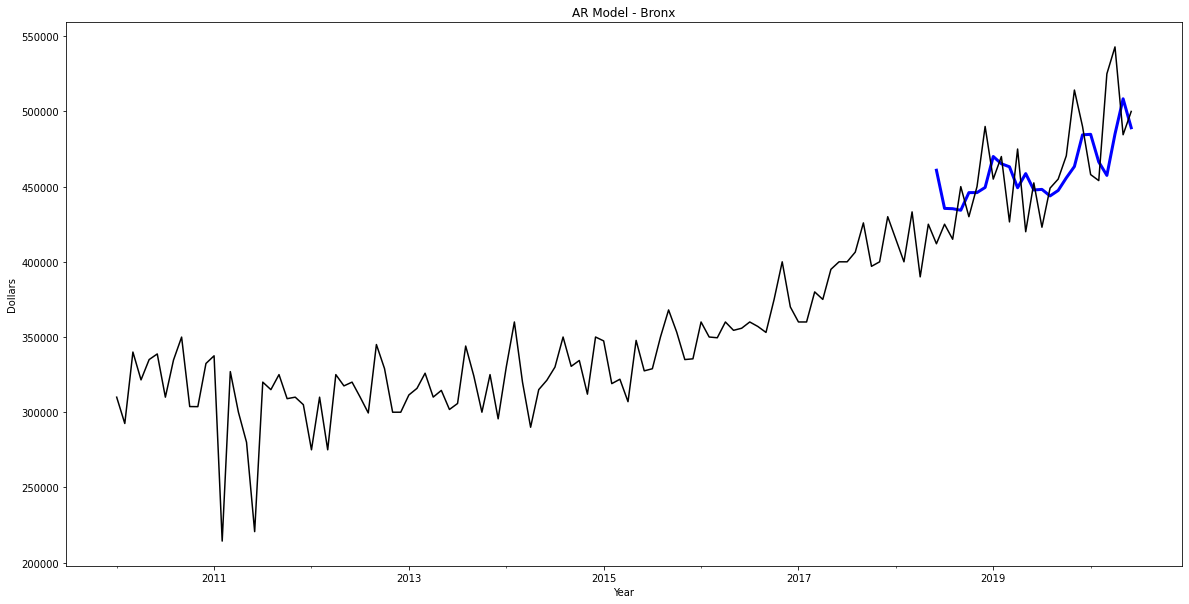

In [1078]:
plt.figure(figsize=(20,10))
pred_prices.plot(color='blue', linewidth=3)
bronx_sales_data['value'].plot(color='black')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.title('AR Model - Bronx')
plt.savefig('AR_Model_Bronx.png')

### AR Model - Queens

In [247]:
dickey_fuller_test(queens_sales_data['value'])

Test statistic = -2.603
P-value = 0.278
Critical values :
	1%: -4.038307389431779 - The data is not stationary with 99% confidence
	5%: -3.448703208559121 - The data is not stationary with 95% confidence
	10%: -3.149449845280976 - The data is not stationary with 90% confidence


In [248]:
dickey_fuller_test(queens_sales_data['value'].diff()[1:])

Test statistic = -2.987
P-value = 0.136
Critical values :
	1%: -4.042734832692444 - The data is not stationary with 99% confidence
	5%: -3.4508097122615675 - The data is not stationary with 95% confidence
	10%: -3.1506786195618557 - The data is not stationary with 90% confidence


In [249]:
dickey_fuller_test(queens_sales_data['value'].diff().diff()[2:])

Test statistic = -7.983
P-value = 0.000
Critical values :
	1%: -4.042734832692444 - The data is  stationary with 99% confidence
	5%: -3.4508097122615675 - The data is  stationary with 95% confidence
	10%: -3.1506786195618557 - The data is  stationary with 90% confidence


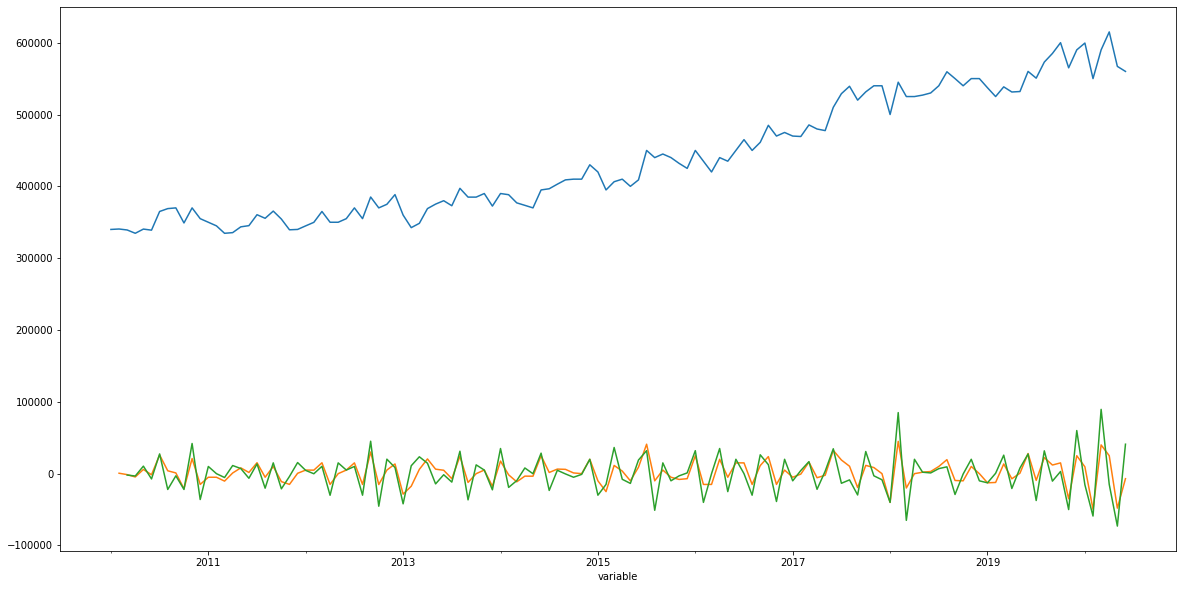

In [250]:
plt.figure(figsize=(20,10))
queens_sales_data['value'].plot()
queens_sales_data['value'].diff()[1:].plot()
queens_sales_data['value'].diff().diff()[2:].plot()

In [251]:
testing_set_values = queens_sales_data['value'][test_dates:]
testing_set = queens_sales_data['value'][test_dates:]
training_set = queens_sales_data['value'][training_dates_start:training_dates_end]

<Figure size 1440x720 with 0 Axes>

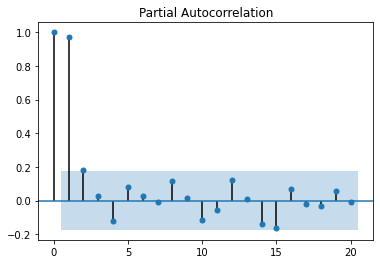

<Figure size 1440x720 with 0 Axes>

In [253]:
plot_pacf(queens_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

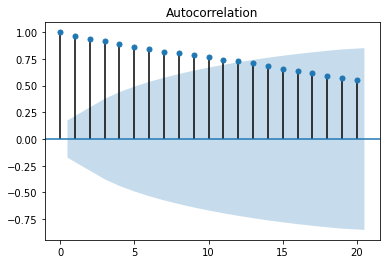

<Figure size 1440x720 with 0 Axes>

In [254]:
plot_acf(queens_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

In [255]:
run_arma(training_set,2,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(2, 0)   Log Likelihood               -1110.756
Method:                       css-mle   S.D. of innovations          14200.665
Date:                Tue, 11 Aug 2020   AIC                           2229.511
Time:                        12:08:51   BIC                           2239.972
Sample:                    01-01-2010   HQIC                          2233.746
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.079e+05   6.93e+04      5.885      0.000    2.72e+05    5.44e+05
ar.L1.value     0.7140      0.095      7.507      0.000       0.528       0.900
ar.L2.value     0.2737      0.096      2.852      0.004       0.086       0.462
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0097           +0.0000j            1.0097            0.0000
AR.2           -3.6184           +0.0000j            3.6184            0.5000
-----------------------------------------------------------------------------
"""

In [256]:
run_arma(testing_set, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -283.010
Method:                       css-mle   S.D. of innovations          19797.737
Date:                Tue, 11 Aug 2020   AIC                            572.019
Time:                        12:08:55   BIC                            575.676
Sample:                    06-01-2018   HQIC                           573.033
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.581e+05   8947.475     62.370      0.000    5.41e+05    5.76e+05
ar.L1.value     0.5778      0.161      3.588      0.000       0.262       0.893
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7308           +0.0000j            1.7308            0.0000
-----------------------------------------------------------------------------
"""

In [257]:
mod_arma = ARMA(testing_set, order=(2,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


19923.330462030655

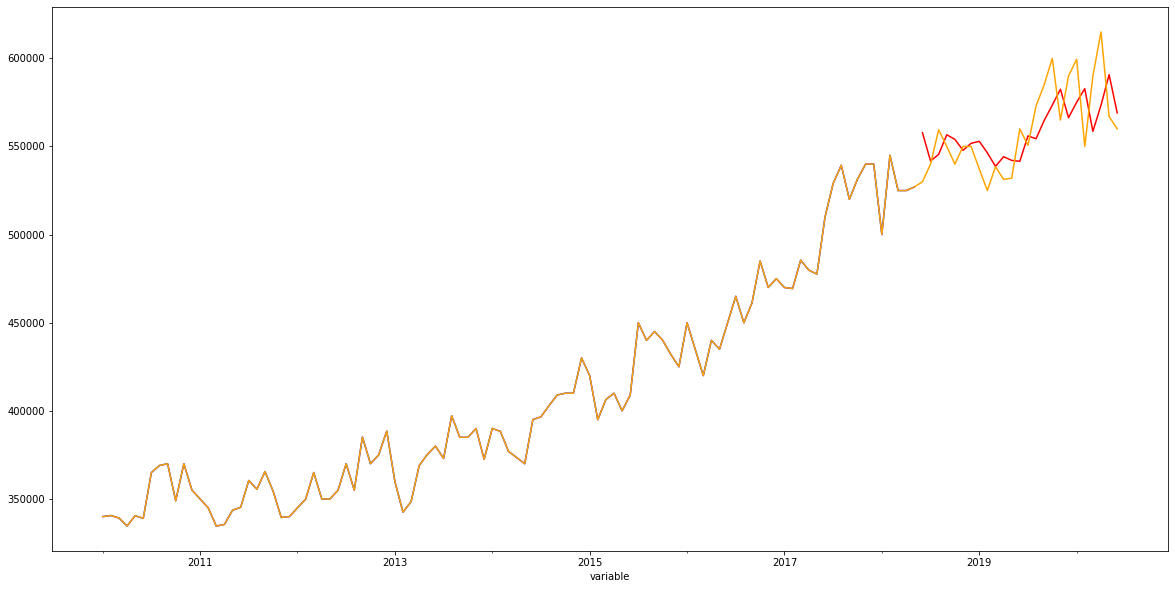

In [259]:
plt.figure(figsize=(20,10))
pred_prices.plot(color='red')
training_set.plot(color='blue')
queens_sales_data['value'].plot(color='orange')

### AR Model - Staten Island

In [260]:
dickey_fuller_test(staten_island_sales_data['value'])

Test statistic = -2.405
P-value = 0.377
Critical values :
	1%: -4.034323572017774 - The data is not stationary with 99% confidence
	5%: -3.446805955734612 - The data is not stationary with 95% confidence
	10%: -3.1483426003846597 - The data is not stationary with 90% confidence


In [262]:
dickey_fuller_test(staten_island_sales_data['value'].diff()[1:])

Test statistic = -8.206
P-value = 0.000
Critical values :
	1%: -4.035606405915461 - The data is  stationary with 99% confidence
	5%: -3.447417080919031 - The data is  stationary with 95% confidence
	10%: -3.148699310749108 - The data is  stationary with 90% confidence


In [263]:
testing_set_values = staten_island_sales_data['value'][test_dates:]
testing_set = staten_island_sales_data['value'][test_dates:]
training_set = staten_island_sales_data['value'][training_dates_start:training_dates_end]

<Figure size 1440x720 with 0 Axes>

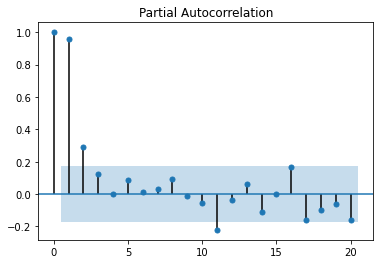

<Figure size 1440x720 with 0 Axes>

In [264]:
plot_pacf(staten_island_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

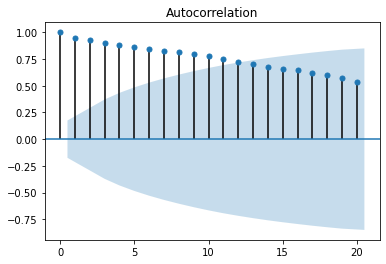

<Figure size 1440x720 with 0 Axes>

In [265]:
plot_acf(staten_island_sales_data['value'], lags=20)
plt.figure(figsize=(20,10))

In [266]:
run_arma(training_set,2,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(2, 0)   Log Likelihood               -1108.282
Method:                       css-mle   S.D. of innovations          13899.624
Date:                Tue, 11 Aug 2020   AIC                           2224.563
Time:                        12:46:59   BIC                           2235.024
Sample:                    01-01-2010   HQIC                          2228.798
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.052e+05   4.77e+04      8.497      0.000    3.12e+05    4.99e+05
ar.L1.value     0.6165      0.093      6.661      0.000       0.435       0.798
ar.L2.value     0.3607      0.094      3.841      0.000       0.177       0.545
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0170           +0.0000j            1.0170            0.0000
AR.2           -2.7261           +0.0000j            2.7261            0.5000
-----------------------------------------------------------------------------
"""

In [267]:
run_arma(testing_set, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -275.972
Method:                       css-mle   S.D. of innovations          14923.496
Date:                Tue, 11 Aug 2020   AIC                            557.943
Time:                        12:47:28   BIC                            561.600
Sample:                    06-01-2018   HQIC                           558.958
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.252e+05   7275.343     72.189      0.000    5.11e+05    5.39e+05
ar.L1.value     0.6082      0.169      3.605      0.000       0.278       0.939
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6441           +0.0000j            1.6441            0.0000
-----------------------------------------------------------------------------
"""

In [268]:
mod_arma = ARMA(testing_set, order=(2,0))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


14942.486539680694

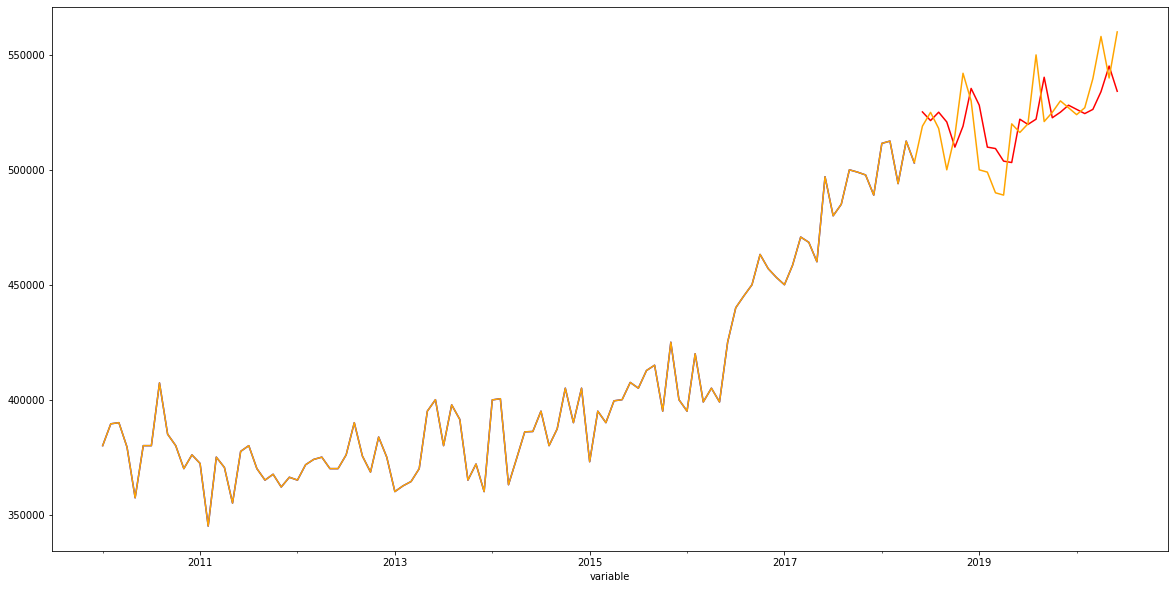

In [270]:
plt.figure(figsize=(20,10))
pred_prices.plot(color='red')
training_set.plot(color='blue')
staten_island_sales_data['value'].plot(color='orange')

### ARMA Model

<p> Running Manhattan Models. Integrating both AR and MA components of testing.</p>

In [1356]:
testing_set_values = manhattan_sales_data['value'][test_dates:]
testing_set = manhattan_sales_data['value'][test_dates:]
training_set = manhattan_sales_data['value'][training_dates_start:training_dates_end]

In [1357]:
run_arma(training_set,1,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(1, 1)   Log Likelihood               -1252.927
Method:                       css-mle   S.D. of innovations          58430.681
Date:                Wed, 12 Aug 2020   AIC                           2513.854
Time:                        04:24:52   BIC                           2524.314
Sample:                    01-01-2010   HQIC                          2518.088
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.056e+05   1.02e+05      8.897      0.000    7.06e+05    1.11e+06
ar.L1.value     0.9855      0.017     59.499      0.000       0.953       1.018
ma.L1.value    -0.6149      0.099     -6.242      0.000      -0.808      -0.422
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0148           +0.0000j            1.0148            0.0000
MA.1            1.6263           +0.0000j            1.6263            0.0000
-----------------------------------------------------------------------------
"""

In [1358]:
run_arma(testing_set,1,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 1)   Log Likelihood                -327.966
Method:                       css-mle   S.D. of innovations         120398.976
Date:                Wed, 12 Aug 2020   AIC                            663.931
Time:                        04:24:53   BIC                            668.807
Sample:                    06-01-2018   HQIC                           665.283
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.066e+06   3.19e+04     33.376      0.000       1e+06    1.13e+06
ar.L1.value     0.3543      0.566      0.626      0.531      -0.755       1.463
ma.L1.value    -0.1319      0.582     -0.227      0.821      -1.272       1.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8228           +0.0000j            2.8228            0.0000
MA.1            7.5793           +0.0000j            7.5793            0.0000
-----------------------------------------------------------------------------
"""

In [1359]:
mod_arma = ARMA(testing_set, order=(2,5))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


105597.60506663151

In [1360]:
pm.metrics.smape(testing_set, pred_prices)

7.053940927993806

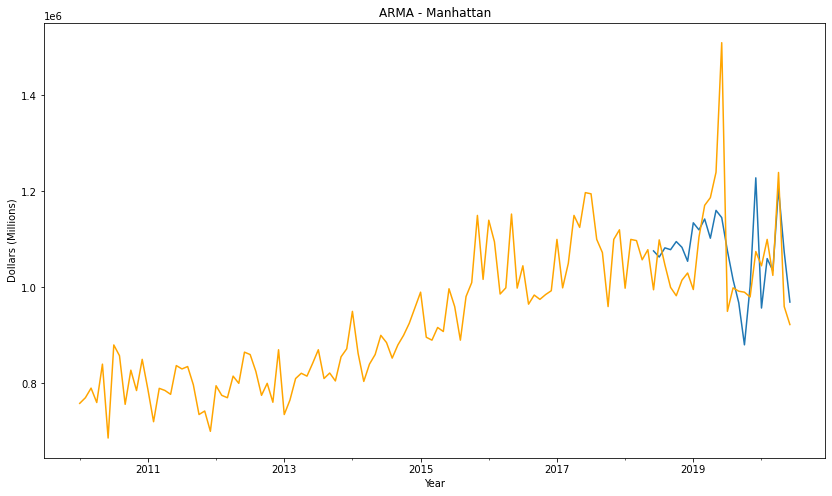

In [1348]:
plt.figure(figsize=(14,8))
pred_prices.plot()
manhattan_sales_data['value'].plot(color='orange')
plt.xlabel('Year')
plt.ylabel('Dollars (Millions)')
plt.title('ARMA - Manhattan')
plt.savefig('ARMA_Manhattan.png')

### ARMA Model - Bronx

In [1362]:
testing_set_values = bronx_sales_data['value'][test_dates:]
testing_set = bronx_sales_data['value'][test_dates:]
training_set = bronx_sales_data['value'][training_dates_start:training_dates_end]

In [1363]:
run_arma(training_set,1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:                     ARMA(1, 1)   Log Likelihood               -1159.552
Method:                       css-mle   S.D. of innovations          23169.833
Date:                Wed, 12 Aug 2020   AIC                           2327.104
Time:                        04:28:32   BIC                           2337.565
Sample:                    01-01-2010   HQIC                          2331.339
                         - 05-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.37e+05   4.87e+04      6.918      0.000    2.42e+05    4.32e+05
ar.L1.value     0.9920      0.013     77.287      0.000       0.967       1.017
ma.L1.value    -0.7477      0.059    -12.735      0.000      -0.863      -0.633
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0080           +0.0000j            1.0080            0.0000
MA.1            1.3374           +0.0000j            1.3374            0.0000
-----------------------------------------------------------------------------
"""

In [1364]:
run_arma(testing_set,1,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                -293.261
Method:                       css-mle   S.D. of innovations          29900.837
Date:                Wed, 12 Aug 2020   AIC                            592.522
Time:                        04:28:32   BIC                            596.178
Sample:                    06-01-2018   HQIC                           593.536
                         - 06-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         4.61e+05   1.16e+04     39.770      0.000    4.38e+05    4.84e+05
ar.L1.value     0.5037      0.180      2.792      0.005       0.150       0.857
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9852           +0.0000j            1.9852            0.0000
-----------------------------------------------------------------------------
"""

In [1365]:
mod_arma = ARMA(testing_set, order=(2,2))
res_arma = mod_arma.fit()
pred_prices = res_arma.predict()
np.sqrt(metrics.mean_squared_error(testing_set, pred_prices))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


29594.722992647126

In [1366]:
pm.metrics.smape(testing_set, pred_prices)

5.233591042166998

In [1367]:
pred_prices

variable
2018-06-01    460664.926445
2018-07-01    433932.104420
2018-08-01    434523.140885
2018-09-01    430687.913744
2018-10-01    443309.785345
2018-11-01    440372.365237
2018-12-01    447866.241090
2019-01-01    465975.199089
2019-02-01    461031.881283
2019-03-01    464377.907319
2019-04-01    448897.077134
2019-05-01    461302.092968
2019-06-01    444427.379983
2019-07-01    450933.500201
2019-08-01    440593.524143
2019-09-01    448108.236621
2019-10-01    451718.115008
2019-11-01    461578.862503
2019-12-01    481101.332959
2020-01-01    482133.240073
2020-02-01    468419.174616
2020-03-01    462471.683276
2020-04-01    486091.273090
2020-05-01    504903.265359
2020-06-01    489081.816003
Freq: MS, dtype: float64

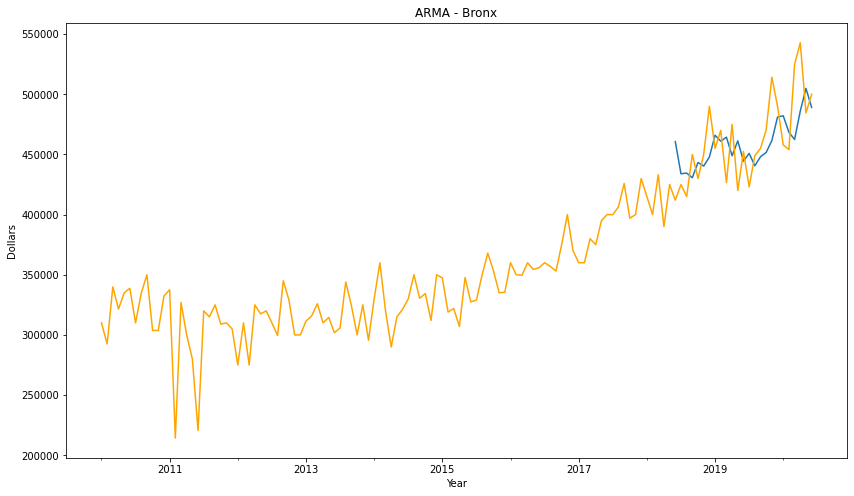

In [1355]:
plt.figure(figsize=(14,8))
pred_prices.plot()
bronx_sales_data['value'].plot(color='orange')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.title('ARMA - Bronx')
plt.savefig('ARMA_Bronx.png')

### ARIMA Models

#### Manhattan Median Asking Price

In [1092]:
testing_set_values = manhattan_sales_data['value'][test_dates:]
testing_set = manhattan_sales_data['value'][test_dates:]
training_set = manhattan_sales_data['value'][training_dates_start:training_dates_end]

In [1093]:
mod_arima = ARIMA(training_set, order=(2,1,1))
res_arima = mod_arima.fit()
res_arima.summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  100
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1237.035
Method:                       css-mle   S.D. of innovations          56757.837
Date:                Wed, 12 Aug 2020   AIC                           2484.069
Time:                        03:05:52   BIC                           2497.095
Sample:                    02-01-2010   HQIC                          2489.341
                         - 05-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3349.1233   1039.095      3.223      0.001    1312.535    5385.712
ar.L1.D.value     0.2342      0.122      1.915      0.056      -0.006       0.474
ar.L2.D.value     0.1329      0.115      1.158      0.247      -0.092       0.358
ma.L1.D.value    -0.8958      0.069    -13.033      0.000      -1.030      -0.761
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0001           +0.0000j            2.0001            0.0000
AR.2           -3.7629           +0.0000j            3.7629            0.5000
MA.1            1.1164           +0.0000j            1.1164            0.0000
-----------------------------------------------------------------------------
"""

In [1104]:
model = ARIMA(testing_set, order=(2,0,4))
model_fit = model.fit()
pred_prices = model_fit.predict()
print(np.sqrt(metrics.mean_squared_error(testing_set, pred_prices)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:

112344.08696038528


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [1105]:
pm.metrics.smape(testing_set, pred_prices)

8.071121757306585

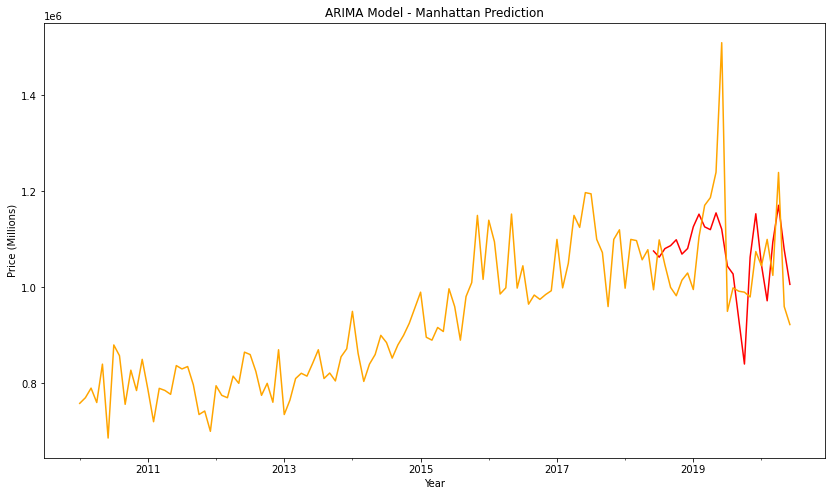

In [1106]:
plt.figure(figsize=(14,8))
pred_prices.plot(color='red')
manhattan_sales_data['value'].plot(color='orange')
plt.title('ARIMA Model - Manhattan Prediction')
plt.xlabel('Year')
plt.ylabel('Price (Millions)')
plt.savefig('ARIMA_Manhattan.png')

### Bronx ARIMA

In [1107]:
testing_set_values = bronx_sales_data['value'][test_dates:]
testing_set = bronx_sales_data['value'][test_dates:]
training_set = bronx_sales_data['value'][training_dates_start:training_dates_end]

In [1108]:
mod_arima = ARIMA(training_set, order=(2,1,1))
res_arima = mod_arima.fit()
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  100
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1144.604
Method:                       css-mle   S.D. of innovations          22509.585
Date:                Wed, 12 Aug 2020   AIC                           2299.208
Time:                        03:12:42   BIC                           2312.234
Sample:                    02-01-2010   HQIC                          2304.480
                         - 05-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           996.3383    530.439      1.878      0.060     -43.303    2035.980
ar.L1.D.value    -0.1264      0.135     -0.939      0.348      -0.390       0.138
ar.L2.D.value    -0.1839      0.122     -1.504      0.132      -0.423       0.056
ma.L1.D.value    -0.6997      0.106     -6.612      0.000      -0.907      -0.492
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3438           -2.3067j            2.3322           -0.2735
AR.2           -0.3438           +2.3067j            2.3322            0.2735
MA.1            1.4291           +0.0000j            1.4291            0.0000
-----------------------------------------------------------------------------
"""

In [1118]:
model = ARIMA(testing_set, order=(3,0,2))
model_fit = model.fit()
pred_prices = model_fit.predict()
print(np.sqrt(metrics.mean_squared_error(testing_set, pred_prices)))

26285.94410281217


In [1116]:
pm.metrics.smape(test, forecasts)

8.276266704089426

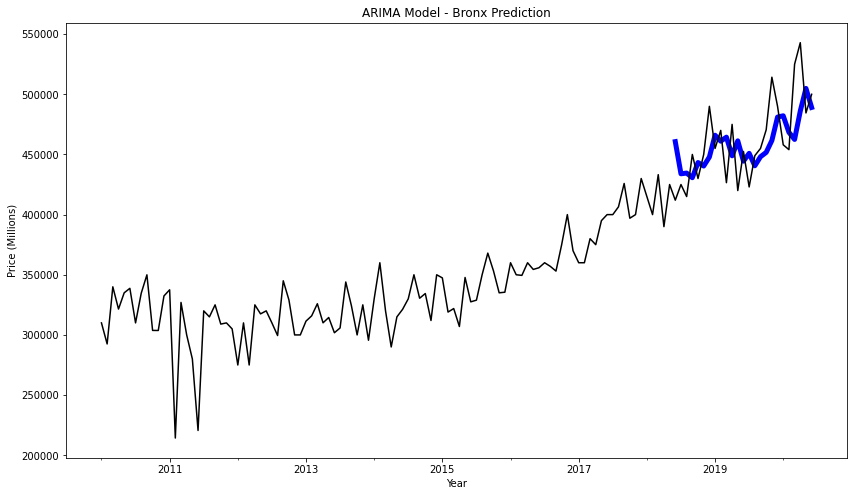

In [691]:
plt.figure(figsize=(14,8))
pred_prices.plot(color='blue', linewidth=5)
bronx_sales_data['value'].plot(color='black')
plt.title('ARIMA Model - Bronx Prediction')
plt.xlabel('Year')
plt.ylabel('Price (Millions)')
plt.savefig('ARIMA_Bronx.png')

### AUTO ARIMA Modeling

#### Manhattan Sales Data

In [693]:
train, test = train_test_split(manhattan_sales_data['value'], train_size=101)

In [694]:
model = pm.auto_arima(train, m=12, start_p=1, start_q=1, d=1, D=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [695]:
forecasts = model.predict(test.shape[0])

In [696]:
new_index = pd.date_range(start='2018-06-01', end='2020-07-01', freq='M')

In [697]:
new_index = new_index - pd.offsets.MonthBegin(1, normalize=True)

In [698]:
result_df = pd.DataFrame(index=new_index)

In [699]:
result_df['value'] = forecasts

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


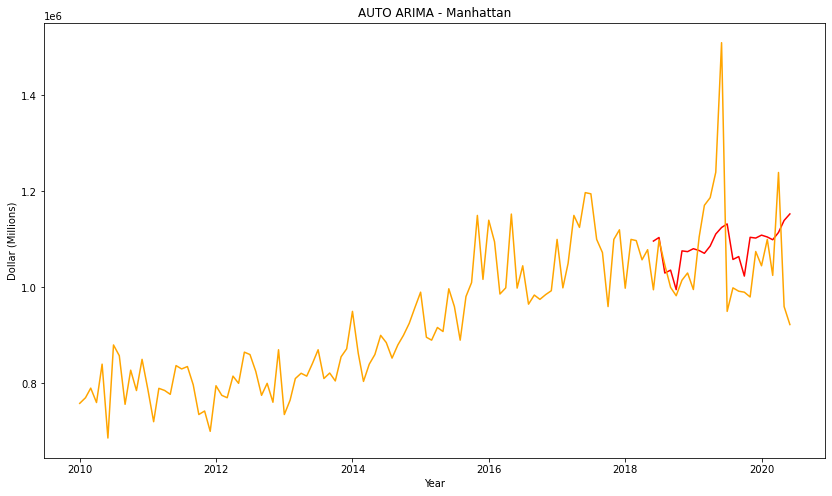

In [704]:
plt.figure(figsize=(14,8))
plt.plot(result_df['value'], c='red')
plt.plot(manhattan_sales_data['value'], c='orange')
plt.title('AUTO ARIMA - Manhattan')
plt.xlabel('Year')
plt.ylabel('Dollar (Millions)')
plt.savefig('AUTO_ARIMA_Manhattan.png')

In [701]:
np.sqrt(metrics.mean_squared_error(test, forecasts))

123436.43431406537

In [702]:
pm.metrics.smape(test, forecasts)

8.276266704089426

#### Bronx Sales Auto Arima

In [705]:
bronx_train, bronx_test = train_test_split(bronx_sales_data['value'], train_size=101)

In [706]:
bronx_model = pm.auto_arima(bronx_train,m=12, start_p=1, start_q=1, d=1, D=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. 

In [707]:
bronx_forecasts = bronx_model.predict(bronx_test.shape[0])

In [708]:
new_index = pd.date_range(start='2018-06-01', end='2020-07-01', freq='M')
new_index = new_index - pd.offsets.MonthBegin(1, normalize=True)

In [709]:
bronx_result_df = pd.DataFrame(index=new_index)

In [710]:
bronx_result_df['value'] = bronx_forecasts

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


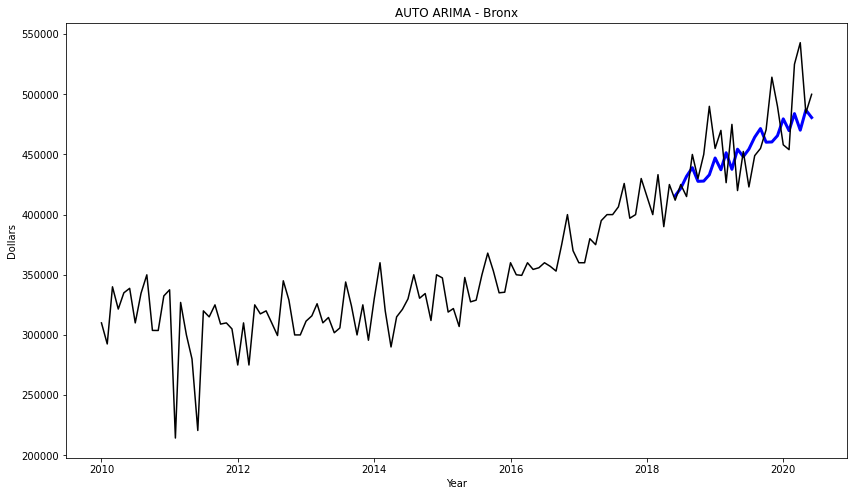

In [718]:
plt.figure(figsize=(14,8))
plt.plot(bronx_result_df['value'], c='blue', linewidth=3)
plt.plot(bronx_sales_data['value'], c='black')
plt.title('AUTO ARIMA - Bronx')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.savefig('AUTO_ARIMA_BRONX.png')

In [719]:
np.sqrt(metrics.mean_squared_error(bronx_test, bronx_forecasts))

29444.452899934728

In [720]:
pm.metrics.smape(bronx_test, bronx_forecasts)

5.001951209996076

#### Staten Island ARIMA

In [592]:
si_train, si_test = train_test_split(staten_island_sales_data['value'], train_size=101)

In [593]:
si_model = pm.auto_arima(si_train, start_p=1, start_q=1, d=1, D=1,m=12)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal movi

In [594]:
si_forecasts = si_model.predict(si_test.shape[0])

In [595]:
si_result_df = pd.DataFrame(index=new_index)

In [596]:
si_result_df['value'] = si_forecasts

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


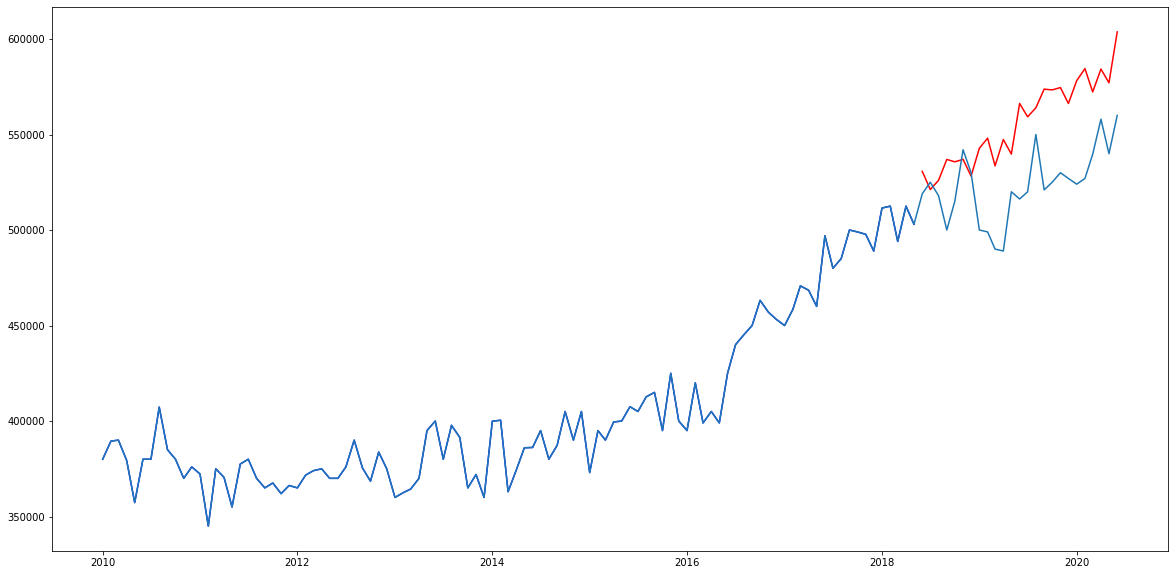

In [597]:
plt.figure(figsize=(20,10))
plt.plot(si_train, c='blue')
plt.plot(si_result_df['value'], c='red')
plt.plot(staten_island_sales_data['value'])
plt.show()

In [599]:
np.sqrt(metrics.mean_squared_error(si_test, si_forecasts))

38020.73212955251

In [535]:
pm.metrics.smape(si_test, si_forecasts)

6.216975240633258

#### Brooklyn ARIMA

In [607]:
bk_train, bk_test = train_test_split(brooklyn_sales_data['value'], train_size=101)

In [608]:
bk_model = pm.auto_arima(bk_train, start_p=1, start_q=1, d=1, D=1,m=12)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal movi

In [609]:
bk_forecasts = bk_model.predict(bk_test.shape[0])

In [610]:
bk_result_df = pd.DataFrame(index=new_index)

In [611]:
bk_result_df['value'] = bk_forecasts

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


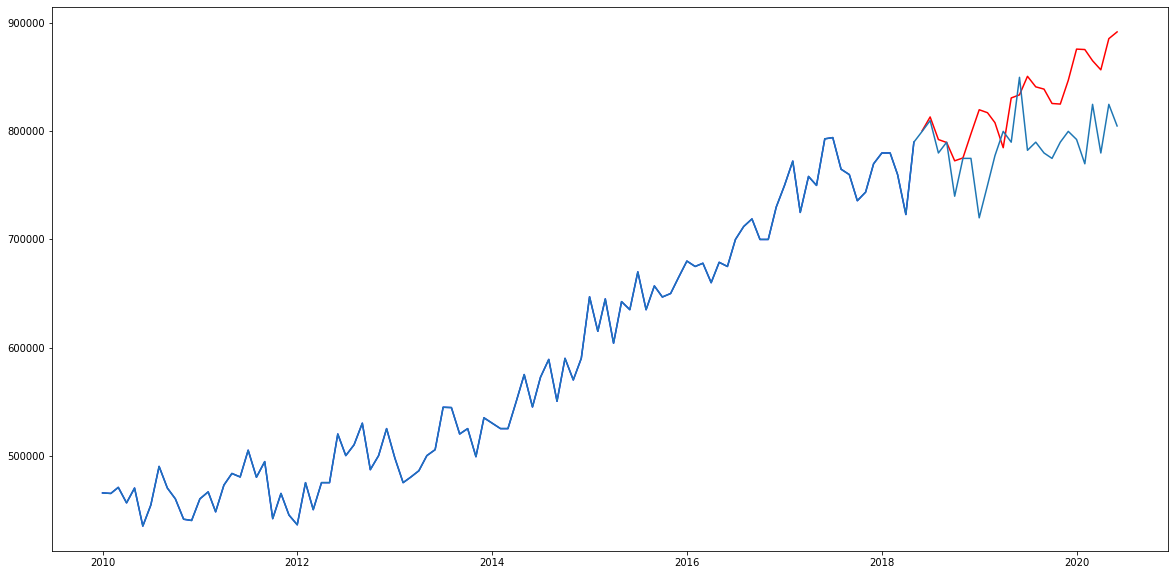

In [612]:
plt.figure(figsize=(20,10))
plt.plot(bk_train, c='blue')
plt.plot(bk_result_df['value'], c='red')
plt.plot(brooklyn_sales_data['value'])
plt.show()

In [613]:
np.sqrt(metrics.mean_squared_error(bk_test, bk_forecasts))

54114.461852664885

In [614]:
pm.metrics.smape(bk_test, bk_forecasts)

5.459495388071567

### SARIMAX Model

#### Manhattan Model

In [1333]:
testing_set_values = manhattan_sales_data['value'][test_dates:]
testing_set = manhattan_sales_data['value'][test_dates:]
training_set = manhattan_sales_data['value'][training_dates_start:training_dates_end]

mod = sm.tsa.statespace.SARIMAX(endog = training_set, trend='ctt', order=(4,1,3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [1334]:
res = mod.fit(disp=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1335]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -1246.305
Date:                Wed, 12 Aug 2020   AIC                           2514.609
Time:                        03:40:42   BIC                           2543.266
Sample:                    01-01-2010   HQIC                          2526.207
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.526e+04     98.280   -155.278      0.000   -1.55e+04   -1.51e+04
drift       1323.0022   2789.816      0.474      0.635   -4144.936    6790.941
trend.2      -12.7763     35.032     -0.365      0.715     -81.437      55.884
ar.L1         -2.5177      0.473     -5.322      0.000      -3.445      -1.590
ar.L2         -2.6625      0.841     -3.166      0.002      -4.311      -1.014
ar.L3         -1.2626      0.664     -1.901      0.057      -2.564       0.039
ar.L4         -0.1747      0.157     -1.115      0.265      -0.482       0.132
ma.L1          2.3442      0.472      4.970      0.000       1.420       3.269
ma.L2          2.2264      0.732      3.041      0.002       0.792       3.661
ma.L3          0.7955      0.460      1.731      0.083      -0.105       1.696
sigma2      3.154e+09      0.001   4.35e+12      0.000    3.15e+09    3.15e+09
===================================================================================
Ljung-Box (Q):                       45.84   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.24   Prob(JB):                         0.99
Heteroskedasticity (H):               1.67   Skew:                            -0.03
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+29. Standard errors may be unstable.
"""

In [1336]:
start_date = testing_set.index[0]
end_date = testing_set.index[-1]

In [1337]:
predictions = res.predict(start=start_date, end=end_date)

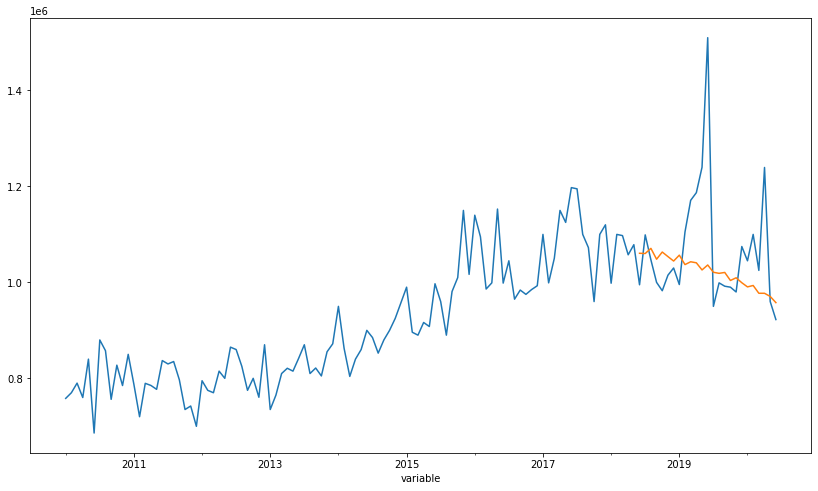

In [1338]:
plt.figure(figsize=(14,8))
manhattan_sales_data['value'].plot()
predictions.plot()

In [1339]:
np.sqrt(metrics.mean_squared_error(testing_set, predictions))

131615.78508938907

In [1340]:
pm.metrics.smape(testing_set, predictions)

7.822768048498804

#### Bronx Sarimax

In [1157]:
testing_set_values = bronx_sales_data['value'][test_dates:]
testing_set = bronx_sales_data['value'][test_dates:]
training_set = bronx_sales_data['value'][training_dates_start:training_dates_end]

mod = sm.tsa.statespace.SARIMAX(endog = training_set, trend='ct', order=(2,2,2))

In [1158]:
res = mod.fit(disp=False)
res.summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  101
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1175.081
Date:                Wed, 12 Aug 2020   AIC                           2364.161
Time:                        03:32:23   BIC                           2382.327
Sample:                    01-01-2010   HQIC                          2371.511
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -377.6465      0.097  -3877.714      0.000    -377.837    -377.456
drift          4.1723      5.323      0.784      0.433      -6.261      14.606
ar.L1         -0.9980      0.031    -32.552      0.000      -1.058      -0.938
ar.L2          0.0020      0.038      0.054      0.957      -0.073       0.077
ma.L1         -0.0001      2.220  -6.25e-05      1.000      -4.352       4.352
ma.L2         -0.9998      0.084    -11.895      0.000      -1.165      -0.835
sigma2      8.225e+08   2.75e-09   2.99e+17      0.000    8.22e+08    8.22e+08
===================================================================================
Ljung-Box (Q):                       44.17   Jarque-Bera (JB):                29.73
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+35. Standard errors may be unstable.
"""

In [1159]:
predictions = res.predict(start=start_date, end=end_date)

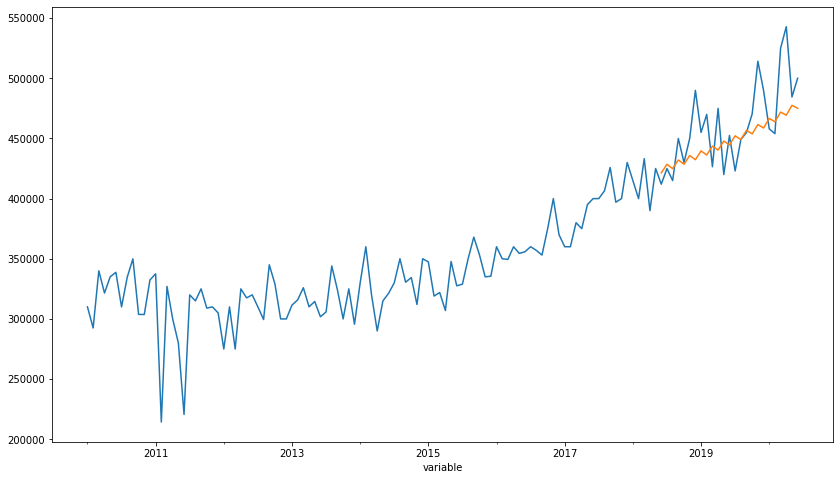

In [1160]:
plt.figure(figsize=(14,8))
bronx_sales_data['value'].plot()
predictions.plot()

In [1161]:
np.sqrt(metrics.mean_squared_error(testing_set, predictions))

29468.14429687212

In [1162]:
pm.metrics.smape(testing_set, predictions)

4.798333874435486

### Multivariate Analysis

In [950]:
manhattan_combined = pd.DataFrame(index=manhattan_sales_data.index)

In [951]:
manhattan_combined['manhattan_sales'] = manhattan_sales_data['value']

In [952]:
manhattan_combined['manhattan_inventory'] = manhattan_inventory_data['value']

In [968]:
manhattan_combined

,manhattan_sales,manhattan_inventory
variable,,
2010-01-01,758250.0,10015
2010-02-01,770000.0,10309
2010-03-01,790000.0,10883
2010-04-01,760000.0,11098
2010-05-01,840000.0,10896
2010-06-01,686000.0,10773
2010-07-01,880000.0,10296
2010-08-01,857616.5,9897
2010-09-01,756250.0,10303


In [974]:
testing_set_values = manhattan_combined[test_dates:]
testing_set = manhattan_combined[test_dates:]
training_set = manhattan_combined[training_dates_start:training_dates_end]

In [985]:
endog = new_data['manhattan_sales']
exog = sm.add_constant(new_data['manhattan_inventory'])

In [990]:
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [992]:
predict = res.get_prediction()

In [993]:
predict_ci = predict.conf_int()

In [996]:
predict